In [1]:
import sys

sys.path.append('..')

from LoadData2 import loadNbackEmoidScansAndAges, loadMeta
# import LoadData2 as LD

pncDir = '../../PNC_Good'

meta = loadMeta(f'{pncDir}/MegaMeta3.pkl')
keys, nbackTs, emoidTs, ages = loadNbackEmoidScansAndAges(meta)

print(nbackTs.shape)
print(emoidTs.shape)
print(ages.shape)
print(ages[0:10])

for key in keys:
    if 'wratStd' not in meta[key]:
        print(key)

(650, 264, 231)
(650, 264, 210)
(650,)
[ 9.66666667 15.58333333 15.83333333 20.16666667 11.41666667 11.58333333
  9.41666667 17.5        15.25        9.58333333]
600444687107
600681250400
600768316020
600891097451
601667746830
601963891187
602212580821
605142512708
605355162443
605576036909
605711237327
605973978786
606111772772
606118165171
606309267666
606637614373
606852399741
606855157085
606860220952
606894204885
607272093553
608070876071
608217385808
609143916322
609270820400
609748609931
609772873811
609912910505
600919368841
609728667591


In [2]:
import pickle
import numpy as np

with open('../../Work/CGConnectivity/10CVSplits.pkl', 'rb') as f:
    groups = pickle.load(f)['groups']
    for group in groups:
        nWrat = 0
        for idx in group[0]:
            if 'wratStd' in meta[keys[idx]]:
                nWrat += 1
        print(nWrat)
        nWrat = 0
        for idx in group[1]:
            if 'wratStd' in meta[keys[idx]]:
                nWrat += 1
        print(nWrat)

532
62
534
60
533
61
536
58
535
59
535
59
535
59
535
59
534
60
537
57


In [4]:
wrat = []
for key in keys:
    if 'wratStd' in meta[key]:
        wrat.append(meta[key]['wratStd'])
    else:
        wrat.append(0)

wrat = np.array(wrat)
print(wrat)

[114 145  93  93 100 101 112  95 125 103  96 100  98  81  89  88 103 108
  94 134 108  92 103  87 110  93  92  75 113 113  92 106 100  93  90 108
  87 117  89  85 103 113  89   0 112 108  99 101  89  94 104  93 124 107
 110 128 134   0 117  90 110 130  87  87  71  85 128  89   0  96 114  97
 100 145  87  71   0 115 144 116  82  92  73 111 100 109 105  88  79 110
 137 125  91  98 112 105  84 103 115  90 108  82 100 102  93 104  80 104
 100 145  93 112  90  92  81 106  92 113 113  74 112 126  93 125  92 105
  76 101 121  76 106 101  96  90 105 100 116 122 102  86 103 113  95  99
 113  98 102  70  93   0 104 102 105 126 111  97 116 145 110 120  78 133
  96  98 113  85  92   0  77  98 105 121 101 136 110  88  94  89  97  73
  80  94   0 102 125  73 114 110  76  85  98  98  98 114  79 125 115 134
 110 117 145 110   0 100 141  94  93 105  78 105 105 145  98 115 113   0
  98 102  96 126 110 114  97 102 102 109  75 111 111 102  91 104 105  99
  98   0  88  89 116 119 105  77  95  95 104 105 14

In [5]:
# Get FC and convert to torch

from LoadData2 import getFC
import torch

nbackP = getFC(nbackTs)
emoidP = getFC(emoidTs)

nbackP_t = torch.from_numpy(nbackP).reshape(650,264*264).float().cuda()
emoidP_t = torch.from_numpy(emoidP).reshape(650,264*264).float().cuda()
feat_t = torch.cat([nbackP_t, emoidP_t], dim=1)
ages_t = torch.from_numpy(ages).float().cuda()
wrat_t = torch.from_numpy(wrat).float().cuda()

print(nbackP_t.shape)
print(emoidP_t.shape)
print(ages_t.shape)

torch.Size([650, 69696])
torch.Size([650, 69696])
torch.Size([650])


In [7]:
import torch.nn as nn
import torch.nn.functional as F

def gradRamLstsq(w, testFeat, labels):
    testFeat = nn.Parameter(testFeat, requires_grad=True)
    pred = testFeat@w
    loss = torch.sum((pred-labels)**2)
    loss.backward()
    ram = torch.sum(F.relu(testFeat.grad*testFeat), dim=0)
    return ram.detach().cpu().numpy()

def gradRamGcn(gcn, feat, testIdcs, testLabels):
    gcn.zero_grad()
    feat = nn.Parameter(feat, requires_grad=True)
    A = CG.cosineSimilarityAdjacency(feat, feat)
    pred = gcn([A, feat]).flatten()[testIdcs]
    loss = gcn.loss(pred, testLabels)
    loss.backward()
    ram = torch.sum(F.relu(feat.grad[testIdcs]*feat[testIdcs]), dim=0)
    return ram.detach().cpu().numpy()

def gradRamCg(cg, trainFeat, trainLabels, testFeat, testLabels):
    testFeat = nn.Parameter(testFeat, requires_grad=True)
    ram = CG.evalCG(cg, trainFeat, trainLabels, testFeat, testLabels, verbose=False)
    return ram.detach().cpu().numpy()

print('Complete')

Complete


In [23]:
# Load 30 splits

import pickle
import CG
import numpy as np

with open('../../Work/CGConnectivity/10CVSplits.pkl', 'rb') as f:
    groups = pickle.load(f)['groups']
    
ramLstsq = 10*[None]
ramGcn = 10*[None]
ramCg = 10*[None]

feat = feat_t
lbl = wrat
lbl_t = wrat_t
sz = feat.shape[1]
    
for i in range(10):
    trainIdcs = groups[i][0]
    testIdcs = groups[i][1]
#     testIdcs = np.setdiff1d(np.arange(650),trainIdcs)
    trainIdcs = np.setdiff1d(trainIdcs, np.where(wrat == 0)[0])
    testIdcs = np.setdiff1d(testIdcs, np.where(wrat == 0)[0])
    
#     m = np.mean(lbl[trainIdcs])
#     rmse = np.mean((lbl[testIdcs]-m)**2)**0.5
#     print(rmse)
#     continue
    
    trainIdcs = torch.from_numpy(trainIdcs).cuda()
    testIdcs = torch.from_numpy(testIdcs).cuda()
    
    trainFeat = feat[trainIdcs]
    testFeat = feat[testIdcs]
    trainA = CG.cosineSimilarityAdjacency(trainFeat, trainFeat)
    A = CG.cosineSimilarityAdjacency(feat, feat)
    trainLabels = lbl_t[trainIdcs]
    testLabels = lbl_t[testIdcs]
    trainLabels_np = trainLabels.detach().cpu().numpy()
    testLabels_np = testLabels.detach().cpu().numpy()
#     print('Least squares')
#     w, _, _, _ = torch.linalg.lstsq(trainFeat, trainLabels)
#     pred = testFeat@w
#     pred = pred.detach().cpu().numpy()
#     print(np.mean((pred-testLabels_np)**2)**0.5)
#     ramLstsq[i] = gradRamLstsq(w, testFeat, testLabels)
    
#     continue
#     print('GCN')
#     gcn = CG.createGCN([sz,100,1], torch.nn.MSELoss())
#     CG.trainGCN(gcn, trainA, trainFeat, trainLabels, nEpochs=5000, lr=2e-5, verbose=False)
#     pred = gcn([A, feat]).flatten()[testIdcs].detach().cpu().numpy()
#     print(np.mean((pred-testLabels_np)**2)**0.5)
#     ramGcn[i] = gradRamGcn(gcn, feat, testIdcs, testLabels)
    
#     continue
    print('CG')
    cg = CG.createCG([2*sz,100,1], torch.nn.MSELoss())
    CG.trainCG(cg, trainFeat, trainLabels, nEpochs=3, verbose=False) # 50 regular, 5 full, 2 wrat
    wp,wn = CG.evalCG(cg, trainFeat, trainLabels, testFeat, verbose=False)
    print(np.mean((wp-testLabels_np)**2)**0.5)
    print(np.mean((wn-testLabels_np)**2)**0.5)
#     ramCg[i] = gradRamCg(cg, trainFeat, trainLabels, testFeat, testLabels_np)

CG
13.053467721326923
13.047769495828387
CG
11.845884898192745
11.830099457913576
CG


KeyboardInterrupt: 

/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


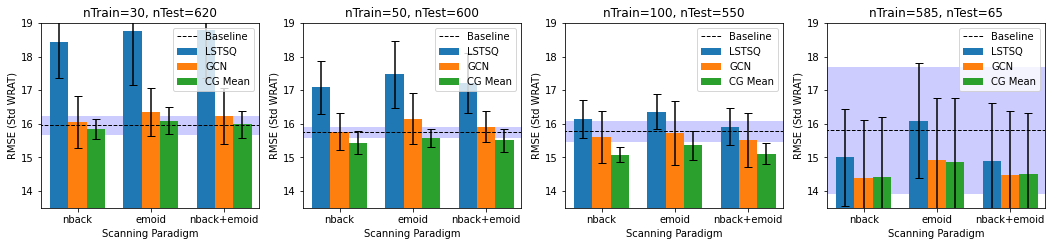

In [26]:
import matplotlib.pyplot as plt
import numpy as np

ind = np.arange(1,4)
width = 0.25

# Age
# lstsq = [(3.336,3.269,3.272),(3.064,2.992,2.961),(2.801,2.765,2.678),(2.358,2.265,2.191)]
# gcn = [(3.185,3.345,3.195),(2.985,2.832,2.861),(2.702,2.621,2.56),(2.302,2.215,2.145)]
# cg = [(2.972,2.959,2.923),(2.806,2.757,2.74),(2.619,2.58,2.524),(2.268,2.209,2.123)]

# lstsqErr = [(0.3455173255,0.1984075491,0.3056432197),
#             (0.1600833116,0.1757397065,0.1543768837),
#             (0.07445356495,0.08922505876,0.07480344615),
#             (0.2755519713,0.3133067365,0.2716390579)]
# gcnErr = [(0.4656476971,0.5170697352,0.405579147),
#           (0.1806316079,0.1643708544,0.1652909892),
#           (0.08547904227,0.09024041962,0.07438637868),
#           (0.2628814689,0.3064220039,0.2712624805)]
# cgErr = [(0.1250599856,0.1327026752,0.1366300764),
#          (0.1104737274,0.1060450638,0.09797958971),
#          (0.08812238964,0.09498537899,0.07471427054),
#          (0.2442130218,0.2906869259,0.2684130316)]

# Wrat
lstsq = [(18.445,18.768,18.804),(17.08,17.474,17.213),(16.147,16.365,15.917),(15.006,16.088,14.902)]
gcn = [(16.061,16.345,16.233),(15.765,16.15,15.917),(15.61,15.722,15.506),(14.389,14.936,14.49)]
cg = [(15.847,16.097,15.987),(15.443,15.573,15.509),(15.078,15.362,15.114),(14.411,14.869,14.494)]

lstsqErr = [(1.085318694,1.618296773,1.44943054),
            (0.8032295922,0.9992241435,0.8924006325),
            (0.5580332527,0.5235402988,0.539836395),
            (1.439623408,1.707491988,1.702715478)]
gcnErr = [(0.7678317235,0.7060256527,0.8403048389),
          (0.5581765949,0.7644024536,0.4678805641),
          (0.7717656524,0.9458541114,0.8031770249),
          (1.729209518,1.842445235,1.899263015)]
cgErr = [(0.3098045979,0.4006674986,0.3992506871),
         (0.3277210874,0.2635674065,0.3396223393),
         (0.2285120955,0.4263227781,0.3125593277),
         (1.781200906,1.885031388,1.837263666)]

fig, ax = plt.subplots(1,4,figsize=(18,3.4))

val = 15.96148968
err = 0.2698976399
ax[0].fill_between([0.75,3.75],[val-err,val-err],[val+err,val+err], color='#ccf')
ax[0].plot([0.5,3.8],[val, val],label='Baseline',color='black',linestyle='dashed',linewidth=1)
val = 15.76126847
err = 0.152734095
ax[1].fill_between([0.75,3.75],[val-err,val-err],[val+err,val+err], color='#ccf')
ax[1].plot([0.5,3.8],[val, val],label='Baseline',color='black',linestyle='dashed',linewidth=1)
val = 15.78504181
err = 0.2974519385
ax[2].fill_between([0.75,3.75],[val-err,val-err],[val+err,val+err], color='#ccf')
ax[2].plot([0.5,3.8],[val, val],label='Baseline',color='black',linestyle='dashed',linewidth=1)
val = 15.81156523
err = 1.876268659
ax[3].fill_between([0.75,3.75],[val-err,val-err],[val+err,val+err], color='#ccf')
ax[3].plot([0.5,3.8],[val, val],label='Baseline',color='black',linestyle='dashed',linewidth=1)

# Age
# ax[0].fill_between([0.75,3.75],[3.33-0.04,3.33-0.04],[3.33+0.04,3.33+0.04], color='#ccf')
# ax[0].plot([0.5,3.8],[3.33, 3.33],label='Baseline',color='black',linestyle='dashed',linewidth=1)
# ax[1].fill_between([0.75,3.75],[3.31-0.03,3.31-0.03],[3.31+0.03,3.31+0.03], color='#ccf')
# ax[1].plot([0.5,3.8],[3.31, 3.31],label='Baseline',color='black',linestyle='dashed',linewidth=1)
# ax[2].fill_between([0.75,3.75],[3.31-0.04,3.31-0.04],[3.31+0.04,3.31+0.04], color='#ccf')
# ax[2].plot([0.5,3.8],[3.31, 3.31],label='Baseline',color='black',linestyle='dashed',linewidth=1)
# ax[3].fill_between([0.75,3.75],[3.26-0.26,3.26-0.26],[3.26+0.26,3.26+0.26], color='#ccf')
# ax[3].plot([0.5,3.8],[3.3, 3.3],label='Baseline',color='black',linestyle='dashed',linewidth=1)

for i in range(0,4):
    ax[i].bar(ind, lstsq[i], width, label='LSTSQ', 
            capsize=4, yerr=lstsqErr[i])
    ax[i].bar(ind + width, gcn[i], width, label='GCN', 
            capsize=4, yerr=gcnErr[i])
    ax[i].bar(ind + 2*width, cg[i], width, label='CG Mean', 
            capsize=4, yerr=cgErr[i])

    ax[i].set_ylabel('RMSE (Std WRAT)')

    ax[i].set_xticks(ind + 1*width)
    ax[i].set_xticklabels(('nback', 'emoid', 'nback+emoid'))
    # ax[0].legend(loc='lower right')
    ax[i].set_xlim(0.75,3.73)
#     ax[i].set_ylim(1.8,4)
    ax[i].set_ylim(13.5,19)

    # ax[0].legend()
    ax[i].set_xlabel('Scanning Paradigm')

ax[0].set_title('nTrain=30, nTest=620')
ax[1].set_title('nTrain=50, nTest=600')
ax[2].set_title('nTrain=100, nTest=550')
ax[3].set_title('nTrain=585, nTest=65')
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
ax[2].legend(loc='upper right')
ax[3].legend(loc='upper right')
    
# fig.suptitle('Age Prediction', y=0.95, fontsize='x-large')
fig.show()
fig.savefig('../../Work/CGConnectivity/WratPrediction.png', format='png', bbox_inches='tight')

In [8]:
import numpy as np

roiMap1 = np.zeros(265,dtype='int')
roiMap2 = np.zeros(265,dtype='int')
revMap2 = np.zeros(264,dtype='int')
roiNames = {}
borders1 = []
borders2 = []

with open('../../PNC/PP264_template.csv', 'r') as f:
    lines = f.readlines()
    for i in range(2,len(lines)):
        line = lines[i].split(',')
        area = int(line[11])
        r1 = int(line[0])
        r2 = int(line[1])
        name = line[14].strip()
        roiMap1[r1] = area
        roiMap2[r2] = area
        roiNames[area] = name
        revMap2[r1-1] = r2-1
#         print([area, r1, r2, name])

last1 = roiMap1[1]
last2 = roiMap2[1]
for i in range(2,265):
    if roiMap1[i] != last1:
        borders1.append(i)
        last1 = roiMap1[i]
    if roiMap2[i] != last2:
        borders2.append(i)
        last2 = roiMap2[i]
    
borders1 = [0] + borders1 + [264]
print(borders1)
print(borders2)

[0, 31, 36, 50, 63, 121, 126, 157, 182, 200, 213, 222, 233, 237, 264]
[13, 42, 47, 61, 74, 84, 86, 132, 133, 137, 138, 139, 140, 143, 174, 182, 186, 203, 221, 222, 235, 243, 247, 251, 253, 255, 256]


In [58]:
def maskDiag(A):
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise Exception('bad A shape')
    return A*(1-np.eye(A.shape[0]))

def rearrange(p,idcs):
    return p[:,idcs][idcs]

def processSingle(A):
    return rearrange(maskDiag(A.reshape([264,264])), revMap2)

def processDouble(A):
    a = rearrange(maskDiag(A[:264*264].reshape([264,264])), revMap2)
    b = rearrange(maskDiag(A[264*264:2*264*264].reshape([264,264])), revMap2)
    return a,b


print('Complete')

Complete


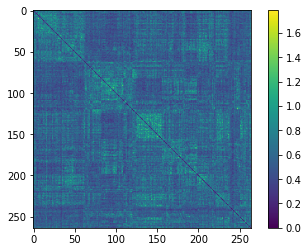

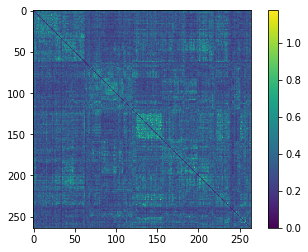

In [184]:
import matplotlib.pyplot as plt

mean = np.mean(np.stack(ramCg),axis=0)
std = np.std(np.stack(ramCg),axis=0)

plt.imshow(processSingle(mean))
plt.colorbar()
plt.show()

plt.imshow(processSingle(std))
plt.colorbar()
plt.show()

In [185]:
for i in range(10):
    print(np.corrcoef(mean, ramCg[i]))

[[1.         0.41882735]
 [0.41882735 1.        ]]
[[1.         0.39562841]
 [0.39562841 1.        ]]
[[1.         0.43173164]
 [0.43173164 1.        ]]
[[1.         0.41381517]
 [0.41381517 1.        ]]
[[1.         0.44243037]
 [0.44243037 1.        ]]
[[1.         0.38649988]
 [0.38649988 1.        ]]
[[1.         0.48468809]
 [0.48468809 1.        ]]
[[1.       0.376251]
 [0.376251 1.      ]]
[[1.         0.35456361]
 [0.35456361 1.        ]]
[[1.         0.48040859]
 [0.48040859 1.        ]]


In [186]:
with open('../../Work/CGConnectivity/Age/30/emoid-cg.pkl', 'wb') as f:
    pickle.dump(ramCg, f)
    
print('Complete')

Complete
